# Messung von Q2 ohne QFP1 Annealing

In [1]:
%matplotlib inline
from qutip import *
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import cmath
from scipy.special import gamma, factorial
from qiskit.quantum_info.states.utils import (_funm_svd)
#import multiprocessing as mp

In [2]:
# Parameter

N = 27
xi = .39 # 10^10 Hz
m = 1/(4 * xi**2)
omega_qfp = 2 * xi
omega_r = 1.2 * omega_qfp
delta = omega_r-omega_qfp

toq1 = 0.09; toqfp1 = 1/toq1
toq2 = 0.12; toqfp2 = 1/toq2

eps1 = toq1*omega_qfp
eps2 = toq2*omega_qfp

eta = m*omega_qfp

def parameter(rde2, rdg):
    
    rde1 = rde2
    
    rde2_eff = rde2 * np.exp(-eta)
    
    Del1 = eps1 * rde1
    Del2 = eps2 * rde2
    
    Del2_eff = eps2 * rde2_eff
    
    omega_q1 = eps1 * cmath.sqrt(1+rde1**2)
    omega_q2 = eps2 * cmath.sqrt(1+rde2**2)
    
    J = (omega_q2-omega_q1)/20
    
    omega_eff2 = toqfp2 * eps2 * cmath.sqrt(1+rde2_eff**2)
    
    delta_eff2 = omega_r - omega_eff2
    theta1 = np.arctan(rde1)
    theta_eff2 = np.arctan(rde2_eff)
    
    g = delta/rdg
    g2 = g*np.sin(theta_eff2)
    
    chi2 = g2**2/delta_eff2
    
    return (J, g2, chi2, theta1, theta_eff2, delta_eff2)

In [3]:
z1 = tensor(sigmaz(), qeye(2), identity(N))
z2 = tensor(qeye(2), sigmaz(), identity(N))
x1 = tensor(sigmax(), qeye(2), identity(N))
x2 = tensor(qeye(2), sigmax(), identity(N))
zz = tensor(sigmaz(), sigmaz(), identity(N))
xz = tensor(sigmax(), sigmaz(), identity(N))
zx = tensor(sigmaz(), sigmax(), identity(N))
xx = tensor(sigmax(), sigmax(), identity(N))
yy = tensor(sigmay(), sigmay(), identity(N))
a = tensor(qeye(2), qeye(2), destroy(N))

In [4]:
def Hamilton(rde2, rdg, alpha):
    
    (J, g2, chi2, theta1, theta_eff2, delta_eff2) = parameter(rde2, rdg)
    
    J *=toqfp2
    
    #HQ1 = -(eps1*z1 + Del1*x1 )/2
    #He2 = -(epsqfp2*z2 + Delqfp2_eff*x2 )/2
    #Hint = g*z2*(a.dag()+a) + omega_r*a.dag()*a + J*z1*z2
    
    #################################################
    # Q2 Eigenbasis
    #################################################
    
    delta2_n = ((delta_eff2  + chi2) + 2*chi2*a.dag()*a)
    delta2_0 = delta_eff2 + chi2
    
    #omega2_n = ((omegaqfp2_eff + chi) + 2*chi*a.dag()*a)
    #omega2_0 = omegaqfp2_eff + chi
    
    J2zz = J * np.cos(theta_eff2)
    J2zx = J* np.sin(theta_eff2)
    
    Hf = - delta2_n/2 *(np.cos(theta_eff2)*z2+np.sin(theta_eff2)*x2) + J*zz # Fluss Basis
    
    H2b = - delta2_n/2 *z2 + J2zz*zz- J2zx*zx #Q2 Energieeigenbasis
    
    omega20_pm = lambda S: cmath.sqrt((delta2_0/2 + np.sign(S)*J2zz)**2 + J2zx**2)
    cos20_pm = lambda S: (delta2_0/2 + np.sign(S)*J2zz)/ cmath.sqrt((delta2_0/2 + np.sign(S)*J2zz)**2 + J2zx**2)
    sin20_pm = lambda S: (-np.sign(S)*J2zx)/ cmath.sqrt((delta2_0/2 + np.sign(S)*J2zz)**2 + J2zx**2)
    
    H2d = -1/2 * ((delta2_n/2 - J2zz)*cos20_pm(-1)+J2zx*sin20_pm(-1)) *(z2+zz)\
    -1/2 * (-(delta2_n/2 - J2zz)*sin20_pm(-1)+J2zx*cos20_pm(-1))*(x2+zx)\
    -1/2 * ((delta2_n/2 + J2zz)*cos20_pm(1)-J2zx*sin20_pm(1))*(z2-zz)\
    -1/2 * (-(delta2_n/2 - J2zz)*sin20_pm(1)-J2zx*cos20_pm(1))*(x2-zx)# dressed Basis
    
    #######################################################
    # Q1 und Q2 Eigenbasis
    #################################################
    
    H3 = - delta2_n/2 * z2+ J*(np.cos(theta1)*np.cos(theta_eff2)*zz\
                               -np.cos(theta1)*np.sin(theta_eff2)*zx\
                               -np.sin(theta1)*np.cos(theta_eff2)*xz\
                               +np.sin(theta1)*np.sin(theta_eff2)*xx) # Q1 und Q2 Basis
    
    # unter der Bedingung $|\cos(\theta_{\text{eff,2}})|, |\cos(\theta_1)| 
    # >> |\sin(\theta_{\text{eff,2}})|, |\sin(\theta_1)|$:
    # theta1 < pi/10; theta2 < pi/4
    
    J3xx = J*np.sin(theta1)*np.sin(theta_eff2)
    J3zz = J*np.cos(theta1)*np.cos(theta_eff2)
    
    H3zz = - delta2_n/2 *z2 + J3zz*zz # bare und dressed Basis
    
    # unter der Bedingung $|\cos(\theta_{\text{eff,2}})|, |\cos(\theta_1)| 
    # << |\sin(\theta_{\text{eff,2}})|, |\sin(\theta_1)|$:
    # theta1: (pi/2.5, pi/2); theta2: (pi/2.1, pi/2)
    
    H3xxb = - delta2_n/2 *z2 + J3xx*xx
    
    omega30 = cmath.sqrt((delta2_0/2)**2 + J3xx**2)
    sin30 = J3xx/ omega30
    cos30_pm = lambda S: (np.sign(S)* delta2_0/2)/ omega30
    
    H3xxd = 1/2*((delta2_n/2 * cos30_pm(-1) - J3xx*sin30)*(z1+z2)\
                 -(delta2_n/2 * sin30 + J3xx*cos30_pm(-1)) *(xx-yy)\
                 +(delta2_n/2 * cos30_pm(1) + J3xx*sin30)*(z1-z2)\
                 +(-delta2_n/2 * sin30 + J3xx*cos30_pm(1))*(xx+yy)) # dressed Basis
    
    return (chi2, Hf, H2b, H2d, H3, H3zz, H3xxb, H3xxd)

In [5]:
def odd (n):
    if (n % 2) == 0:
        return 0
    else:
        return 1

In [6]:
def fid_norm(opr1, opr2):
    
    s1sq = _funm_svd(opr1, np.sqrt)
    s2sq = _funm_svd(opr2, np.sqrt)
    fid = np.linalg.norm(s1sq.dot(s2sq), ord='nuc')**2
    
    return float(np.real(fid))

In [7]:
zus00 = ket("00")
zus01 = ket("01")
zus10 = ket("10")
zus11 = ket("11")

#psi0q1 = (basis(2, 0) + basis(2, 1)).unit()
#psi0q2 = (basis(2, 0) + basis(2, 1)).unit()
psi0_q = (zus00+zus01+zus10+zus11).unit()

rho0_q = ket2dm(psi0_q)
rho0_q1 = psi0_q.ptrace(0)
rho0_q2 = psi0_q.ptrace(1)

In [8]:
def ideal_pm(S):
    
    if np.sign(S) == 1:
            
        Mid = (zus00 * zus00.dag()+zus10 * zus10.dag()) * rho0_q * (zus00 * zus00.dag()+zus10 * zus10.dag())
        
    elif np.sign(S) == -1:
        Mid = (zus01 * zus01.dag()+zus11 * zus11.dag()) * rho0_q * (zus01 * zus01.dag()+zus11 * zus11.dag())
    
    return Mid

In [9]:
def ideal():
      
    ideal_p = ideal_pm(1)
    ideal_m = ideal_pm(-1)
    
    Fid = (ideal_p+ideal_m).ptrace(1)
    
    return Fid

In [10]:
def Mess_pm(H, t, alpha, S):
    
    nsteps = 1000
    while not 'U' in locals():
        try:
            U = propagator(H, t, options = Options(num_cpus=5, rtol = 1e-08, nsteps=nsteps))
        except:
            nsteps *= 10
            if nsteps>10000000:
                raise SystemExit('nsteps too large')
    
    #U = propagator(H, t, options = Options(atol=1e-10, rtol = 1e-08, nsteps=1000000))
    
    F = 0
    
    for l in range(0, N):
        for k in range(0, N):
            fcl = tensor(qeye(2), qeye(2), fock(N, l))
            fck = tensor(qeye(2), qeye(2), fock(N, k))
 
            if l == k:
        
                e = np.exp(-alpha**2)* alpha **(2*l)/(2 * factorial(l))\
                * (fcl.dag()* U * fcl) * rho0_q * (fcl.dag() * U * fcl)
                    
            else:
                e = (-np.sign(S) * np.exp(-alpha**2)) * (1j/np.pi) * alpha **(l+k) \
                * gamma((l+k)/2 + 1)* odd(k-l)/(factorial(k) * factorial(l)*(k-l)) \
                * (fcl.dag() * U * fcl) * rho0_q * (fck.dag() * U * fck)
                     
            F += e
    
    return F

In [11]:
def Mess(H, t, alpha):
    
    M_p = Mess_pm(H, t, alpha, 1)
    M_m = Mess_pm(H, t, alpha, -1)
    
    M = (M_p+M_m).ptrace(1)
    
    return M

In [12]:
def fid(H, t, alpha):
    
    M = Mess(H, t, alpha)
    M_id = ideal()
    
    F = fid_norm(M, M_id)
    
    return F

In [13]:
def main(rde2, rdg, alpha, rtc):
    
    oper = Hamilton(rde2, rdg, alpha)
    
    t = rtc/np.absolute(oper[0])
    
    F = [fid(oper[i], t, alpha) for i in range(1, 4)]

    return F

In [14]:
def mainzz(rde2, rdg, alpha, rtc):
    
    oper = Hamilton(rde2, rdg, alpha)
    
    t = rtc/np.absolute(oper[0])
    
    F = [fid(oper[i], t, alpha) for i in range(4, 6)]

    return F

In [15]:
def mainxx(rde2, rdg, alpha, rtc):
    
    oper = Hamilton(rde2, rdg, alpha)
    
    t = rtc/np.absolute(oper[0])
    
    F = [fid(oper[i], t, alpha) for i in range(len(oper)-2, len(oper))]

    return F

In [16]:
alpha_list = np.arange(.1, 3, .1)

In [17]:
(rde2, rdg, rtc) =(1, 8, np.pi/2)

In [18]:
%time F_alp = [main(rde2, rdg, alpha, rtc) for alpha in alpha_list]

/home/shiji/anaconda3/envs/qutip-env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1012: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


CPU times: user 52min 8s, sys: 1min 22s, total: 53min 30s
Wall time: 29min 3s


In [19]:
%time F_alpzz = [mainzz(rde2, rdg, alpha, rtc) for alpha in alpha_list]

CPU times: user 37min 7s, sys: 58.1 s, total: 38min 6s
Wall time: 20min 36s


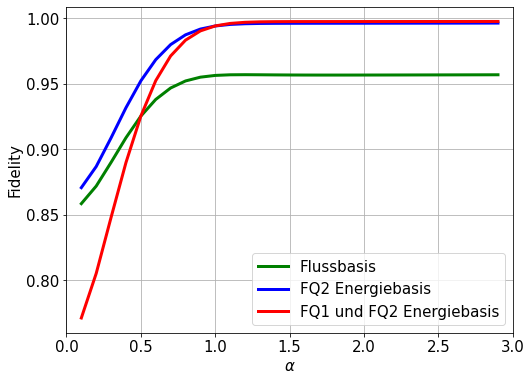

In [20]:
from pylab import rcParams
rcParams.update({'font.size': 15})
rcParams['figure.figsize'] = 8, 6
fig, ax = plt.subplots()

ax.plot(alpha_list, [f[0] for f in F_alp], 'g', label='Flussbasis', linewidth=3)

ax.plot(alpha_list, [f[1] for f in F_alp], 'b', label='FQ2 Energiebasis', linewidth=3)
#ax.plot(alpha_list, [f[2] for f in F_alp], label='FQ2 Energiebasis (dressed)', linewidth=3)

ax.plot(alpha_list, [f[0] for f in F_alpzz], 'r', label='FQ1 und FQ2 Energiebasis', linewidth=3)
#ax.plot(alpha_list, [f[1] for f in F_alpzz], label='FQ1 und FQ2 Energiebasis zz-WW', linewidth=3)

ax.set_xlim(0, 3)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Fidelity')
ax.legend(loc=4)
ax.grid(True)

plt.savefig('2qo_alpha_fq2q1q2.pdf')

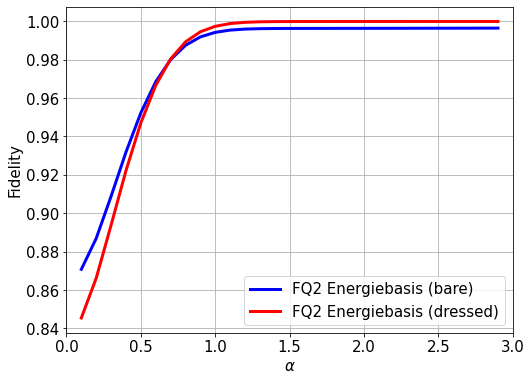

In [21]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
fig, ax = plt.subplots()

#ax.plot(alpha_list, [f[0] for f in F_alp], 'g', label='Flussbasis', linewidth=3)

ax.plot(alpha_list, [f[1] for f in F_alp], 'b', label='FQ2 Energiebasis (bare)', linewidth=3)
ax.plot(alpha_list, [f[2] for f in F_alp], 'r', label='FQ2 Energiebasis (dressed)', linewidth=3)

#ax.plot(alpha_list, [f[0] for f in F_alpzz], 'r', label='FQ1 und FQ2 Energiebasis', linewidth=3)
#ax.plot(alpha_list, [f[1] for f in F_alpzz], label='FQ1 und FQ2 Energiebasis zz-WW', linewidth=3)

ax.set_xlim(0, 3)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Fidelity')
ax.legend(loc=4)
ax.grid(True)

plt.savefig('2qo_alpha_q2.pdf')

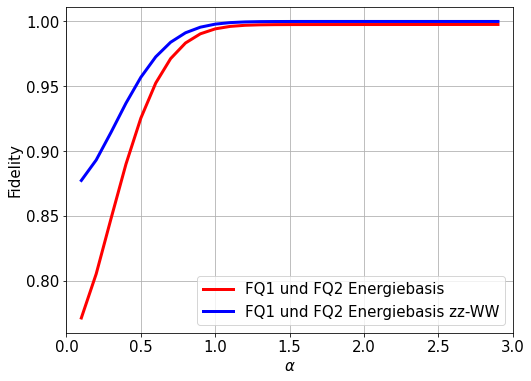

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
fig, ax = plt.subplots()

#ax.plot(alpha_list, [f[0] for f in F_alp], label='Flussbasis', linewidth=3)

#ax.plot(alpha_list, [f[1] for f in F_alp], label='FQ2 Energiebasis (bare)', linewidth=3)
#ax.plot(alpha_list, [f[2] for f in F_alp], label='FQ2 Energiebasis (dressed)', linewidth=3)

ax.plot(alpha_list, [f[0] for f in F_alpzz], 'r', label='FQ1 und FQ2 Energiebasis', linewidth=3)
ax.plot(alpha_list, [f[1] for f in F_alpzz], 'b', label='FQ1 und FQ2 Energiebasis zz-WW', linewidth=3)

ax.set_xlim(0, 3)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Fidelity')
ax.legend(loc=4)
ax.grid(True)

plt.savefig('2qo_alpha_fq1q2zz.pdf')

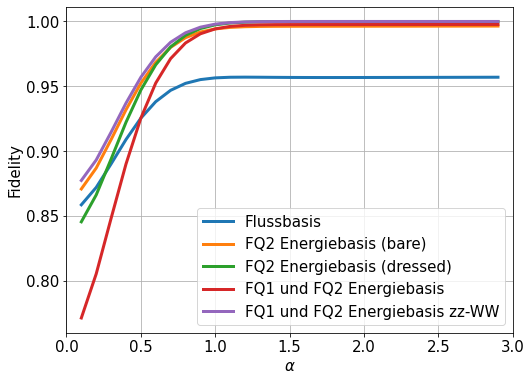

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
fig, ax = plt.subplots()

ax.plot(alpha_list, [f[0] for f in F_alp], label='Flussbasis', linewidth=3)

ax.plot(alpha_list, [f[1] for f in F_alp], label='FQ2 Energiebasis (bare)', linewidth=3)
ax.plot(alpha_list, [f[2] for f in F_alp], label='FQ2 Energiebasis (dressed)', linewidth=3)

ax.plot(alpha_list, [f[0] for f in F_alpzz], label='FQ1 und FQ2 Energiebasis', linewidth=3)
ax.plot(alpha_list, [f[1] for f in F_alpzz], label='FQ1 und FQ2 Energiebasis zz-WW', linewidth=3)

ax.set_xlim(0, 3)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Fidelity')
ax.legend(loc=4)
ax.grid(True)

plt.savefig('2qo_alpha4.pdf')

In [24]:
rde2xx=10

In [25]:
alphaxx_list = np.arange(.1, 3, .1)

In [26]:
(rdg, rtc) =(8, np.pi/2)

In [27]:
%time F_alpxx = [mainxx(rde2xx, rdg, alpha, rtc) for alpha in alphaxx_list]

/home/shiji/anaconda3/envs/qutip-env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1012: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


CPU times: user 4h 53min, sys: 8min 33s, total: 5h 1min 33s
Wall time: 2h 32min 45s


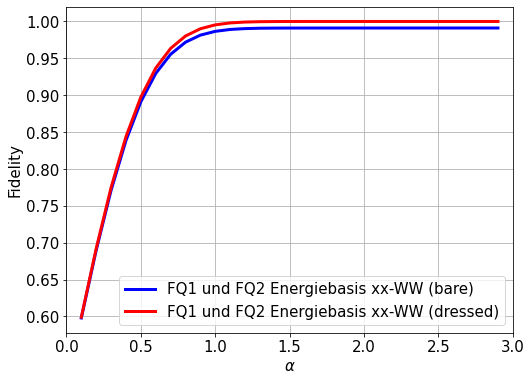

In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
fig, ax = plt.subplots()

#ax.plot(alpha_list, [f[0] for f in F_alp], label='Flussbasis', linewidth=3)

#ax.plot(alpha_list, [f[1] for f in F_alp], label='FQ2 Energiebasis (bare)', linewidth=3)
#ax.plot(alpha_list, [f[2] for f in F_alp], label='FQ2 Energiebasis (dressed)', linewidth=3)

ax.plot(alphaxx_list, [f[0] for f in F_alpxx], 'b', label='FQ1 und FQ2 Energiebasis xx-WW (bare)', linewidth=3)
ax.plot(alphaxx_list, [f[1] for f in F_alpxx], 'r', label='FQ1 und FQ2 Energiebasis xx-WW (dressed)', linewidth=3)

ax.set_xlim(0, 3)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('Fidelity')
ax.legend(loc=4)
ax.grid(True)

plt.savefig('2qo_alpha_fq1q2xx.pdf')